# All Mart - High Value Customer Identification

Identificação de clientes mais valiosos de uma empresa e projecção de um programa de fidelidade para os mesmos.

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

from scipy import stats
import random, os
from IPython.display import HTML, Image



# Preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, OneHotEncoder

# Models
from sklearn.cluster import KMeans, DBSCAN, MiniBatchKMeans
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import NearestNeighbors
from sklearn.mixture import GaussianMixture

# Visualização de clusters
from sklearn.metrics import silhouette_score, silhouette_samples
import umap.umap_ as umap

from scipy.cluster import hierarchy as hc


# Dimensionality Reduction
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Warnings
import warnings
warnings.filterwarnings('ignore')

# 1.0 Data Reading

## 1.1 Data Loading

In [2]:
df1 = pd.read_csv('../data/01_raw/Ecommerce.csv', encoding='unicode_escape')
df1.drop(columns=['Unnamed: 8'], axis=1, inplace=True)
df1.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,29-Nov-16,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,29-Nov-16,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,29-Nov-16,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,29-Nov-16,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,29-Nov-16,3.39,17850.0,United Kingdom


## 1.2 Data Dimensions

In [3]:
print(f'Number of rows: {df1.shape[0]}')
print(f'Number of columns: {df1.shape[1]}')

Number of rows: 541909
Number of columns: 8


## 1.3 Data Dtypes

In [4]:
df1.dtypes

InvoiceNo       object
StockCode       object
Description     object
Quantity         int64
InvoiceDate     object
UnitPrice      float64
CustomerID     float64
Country         object
dtype: object

## 1.4 Checking NA

In [5]:
df1.isna().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

# 2.0 Data Wrangling

In [6]:
df2 = df1.copy()

## 2.1 Rename Columns

In [7]:
cols_new = ['invoice_no', 'stock_code', 'description', 'quantity', 'invoice_date', 'unit_price', 'customer_id', 'country']
df2.columns = cols_new

## 2.2 Replacing NAs

In [8]:
df_missing = df2.loc[df2['customer_id'].isna(), :]
df_not_missing = df2.loc[~df2['customer_id'].isna(), :]

In [9]:
# create reference
df_backup = pd.DataFrame(df_missing['invoice_no'].drop_duplicates())
df_backup['customer_id'] = np.arange(19000, 19000+len(df_backup), 1)


# merge original with reference dataframe
df2 = pd.merge(df2, df_backup, on='invoice_no', how='left')

# coalesce
df2['customer_id'] = df2['customer_id_x'].combine_first(df2['customer_id_y'])

# drop extra columns
df2 = df2.drop(columns=['customer_id_x', 'customer_id_y'], axis=1)

In [10]:
df2.isna().sum()

invoice_no         0
stock_code         0
description     1454
quantity           0
invoice_date       0
unit_price         0
country            0
customer_id        0
dtype: int64

In [13]:
df2.dropna(subset=['description', 'customer_id'], inplace=True)
print(f'Removed data: {1-(df2.shape[0]/df1.shape[0]):.2f}')

Removed data: 0.00


## 2.3 Changing Dtypes

In [15]:
# Invoice Date
df2['invoice_date'] = pd.to_datetime(df2['invoice_date'], format='%d-%b-%y')

# Customer ID
df2['customer_id'] = df2['customer_id'].astype(int)

In [16]:
df2.dtypes

invoice_no              object
stock_code              object
description             object
quantity                 int64
invoice_date    datetime64[ns]
unit_price             float64
country                 object
customer_id              int64
dtype: object

## 2.4 Drop Duplicates

In [17]:
# Create DataFrame Reference

df_ref = df2.drop(['invoice_no', 'stock_code', 'description', 
                   'quantity', 'invoice_date', 'unit_price', 
                   'country'], axis=1).drop_duplicates(ignore_index=True)
df_ref.head()

,customer_id
0,17850
1,13047
2,12583
3,13748
4,15100


## 2.5 Descriptive Statistics

### 2.5.1. Numerical Features

In [18]:
num_cols = df2.select_dtypes(include=['number'])
cat_cols = df2.select_dtypes(exclude=['number', 'datetime64[ns]'])

In [19]:
# Central Tendency - mean, median
ct1 = pd.DataFrame(num_cols.apply(np.mean)).T
ct2 = pd.DataFrame(num_cols.apply(np.median)).T


#  Dispersion - Desvio Padrão, minimo, máximo, range, skew, kurtosis
d1 = pd.DataFrame(num_cols.apply(np.std)).T
d2 = pd.DataFrame(num_cols.apply(np.min)).T
d3 = pd.DataFrame(num_cols.apply(np.max)).T
d4 = pd.DataFrame(num_cols.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_cols.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_cols.apply(lambda x: x.kurtosis())).T

# Concat
descriptive = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
descriptive.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
descriptive

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,quantity,-80995.00,80995.0,161990.00,9.603129,3.00,218.007397,-0.281253,120252.449063
1,unit_price,-11062.06,38970.0,50032.06,4.623519,2.08,96.889538,186.257919,58848.017575
2,customer_id,12346.00,22709.0,10363.00,16678.153600,16241.00,2907.570262,0.493600,-0.792496


Investigar:
1. Quantidade negativa: pode significar "devolução"
2. Preço unitário igual a zero: pode ser promoção


### 2.5.1. Categorical Features

#### Invoice No
Problema: detectamos que Invoice_no apresenta letras além de números. Precisamos converter para inteiro.

In [22]:
df_invoices_cat = cat_cols.loc[cat_cols['invoice_no'].apply(lambda x: bool(re.search('[^0-9+]', x))), 'invoice_no']

# o regex acima procura necessariamente por CARACTERES != de numeros (^) sendo 1 ou mais caracteres.

print(f'Número total de transações: {df_invoices_cat.shape[0]}')
print(f'Número total de quantidades negativas: {df2.loc[df2["quantity"] < 0].shape[0]}')

Número total de transações: 9291
Número total de quantidades negativas: 9762


Podemos assumir que quando há uma letra no "invoice_no" significa que esta transação foi retornada ou cancelada. A letra "C" provalmente é um indicativo de _charge back_ ("estorno", em inglês).

#### Stock Code
Não sabemos o que significam essas siglas, por isso iremos removê-las nesse primeiro momento.

In [23]:
# Stock Code

cat_cols.loc[cat_cols['stock_code'].apply(lambda x: bool(re.search('^[a-zA-Z]+$', x))), 'stock_code'].unique()

# cat_cols.loc[cat_cols['stock_code'].apply(lambda x: bool(re.search('^[a-zA-Z]+$', x))), :].head()
# O regex acima procura por strings que DEVEM começar com uma letra(^), e DEVEM terminar ($) com uma letra OU MAIS (+)

array(['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY',
       'DCGSSGIRL', 'PADS', 'B', 'CRUK'], dtype=object)

#### Description
Iremos também deletar a variável description, por não apresentar informações relevantes neste primeiro momento.

In [24]:
df2['description'].unique()

array(['WHITE HANGING HEART T-LIGHT HOLDER', 'WHITE METAL LANTERN',
       'CREAM CUPID HEARTS COAT HANGER', ..., 'lost',
       'CREAM HANGING HEART T-LIGHT HOLDER',
       'PAPER CRAFT , LITTLE BIRDIE'], dtype=object)

#### Country
Uma das formas de avaliar uma região, é observar o quão representativo cada uma delas é em nosso dataset. Vamos observar a seguir:

In [25]:
df2['country'].unique()

array(['United Kingdom', 'France', 'Australia', 'Netherlands', 'Germany',
       'Norway', 'EIRE', 'Switzerland', 'Spain', 'Poland', 'Portugal',
       'Italy', 'Belgium', 'Lithuania', 'Japan', 'Iceland',
       'Channel Islands', 'Denmark', 'Cyprus', 'Sweden', 'Austria',
       'Israel', 'Finland', 'Bahrain', 'Greece', 'Hong Kong', 'Singapore',
       'Lebanon', 'United Arab Emirates', 'Saudi Arabia',
       'Czech Republic', 'Canada', 'Unspecified', 'Brazil', 'USA',
       'European Community', 'Malta', 'RSA'], dtype=object)

# 3.0 Feature Filtering

Aqui tomaremos as ações decididas na seção anterior para selecionar da melhor forma as nossas features para análise.

In [78]:
df3 = df2.copy()

In [79]:
###### Numerical Cols ######
df3 = df3.loc[df3['unit_price'] > 0.04, :]


###### Categorical Cols ######
df3 = df3.loc[~df3['stock_code'].isin(['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY','DCGSSGIRL', 'PADS', 'B', 'CRUK'])]


# Description
df3 = df3.drop(columns='description', axis=1)


# Map
df3 = df3[~df3['country'].isin(['European Community', 'Unspecified'])]


# Bad Users - Atualizado após Análise Univariada
df3 = df3[~df3['customer_id'].isin([16464])]

# Quantity - negative numbers means product returns
df3_returns = df3.loc[df3['quantity'] < 0, :]
df3_purchases = df3.loc[df3['quantity'] > 0, :]


# 4.0 Feature Engineering

- Algumas ideias:
    
    - Moving average: 7d, 14d, 30d
    - Quantidade de compras por mês: antes do dia 15 e depois do 15;
    - Average Financial
    - Basket Size * Price: Quantidade de preços por cesta
    


In [80]:
df4 = df3.copy()

In [81]:
# data referecen
df_ref = df4.drop(['invoice_no', 'stock_code', 'quantity', 'invoice_date', 'unit_price', 'country'], axis=1).drop_duplicates(ignore_index=True)

## 4.1 Gross Revenue
_Receita Bruta._

In [82]:
# Gross Revenue (Faturamento = Quantidade * Preço)
df3_purchases['gross_revenue'] = df3_purchases['quantity'] * df3_purchases['unit_price']

# Monetary
df_monetary = df3_purchases.loc[:, ['customer_id', 'gross_revenue']].groupby('customer_id').sum().reset_index().rename(columns={'gross_revenue':'monetary'}).copy()
df_ref = pd.merge(df_ref, df_monetary, how='left', on='customer_id')
df_ref.isna().sum()

customer_id     0
monetary       91
dtype: int64

## 4.2 Recency
_Quantidade de dias desde a última compra._

In [83]:
# Recency: Dia da última compra
df_recency = df3_purchases.groupby('customer_id')['invoice_date'].max().reset_index()
df_recency['recency'] = (df3['invoice_date'].max() - df_recency['invoice_date']).dt.days
df_recency = df_recency[['customer_id', 'recency']].copy()
df_ref = pd.merge(df_ref, df_recency, how='left', on='customer_id')
df_ref.isna().sum()

customer_id     0
monetary       91
recency        91
dtype: int64

## 4.4.1 Quantity of products purchased
_Quantidade de produtos (X produtos por item) numa compra._

In [84]:
# Frequency - Contagem do número de compras feitas pelo cliente
df_freq = (df3_purchases[['customer_id', 'stock_code']].groupby('customer_id').count()
                                                    .reset_index()
                                                    .rename(columns={'stock_code':'qtde_products'}))
df_ref = pd.merge(df_ref, df_freq, how='left', on='customer_id')
# df_ref.rename(columns={'gross_revenue':'monetary',
#                'invoice_no':'frequency'},
#              inplace=True)

df_ref.isna().sum()

customer_id       0
monetary         91
recency          91
qtde_products    91
dtype: int64

## 4.7 Frequency Purchase
*Taxa de frequência de compras.*

In [85]:
df_aux47 = (df3_purchases[['customer_id', 'invoice_no', 'invoice_date']].drop_duplicates()
                                                             .groupby('customer_id')
                                                             .agg(max_ = ('invoice_date', 'max'),
                                                                  min_ = ('invoice_date', 'min'),
                                                                  days_ = ('invoice_date', lambda x: ((x.max() - x.min()).days) +1) ,
                                                                  buy_ = ('invoice_no', 'count'))).reset_index()

# Frequency
df_aux47['frequency'] = df_aux47[['buy_', 'days_']].apply(lambda x: x['buy_'] / x['days_'] if x['days_'] != 0 else 0, axis=1)

# Merge
df_ref = pd.merge(df_ref, df_aux47[['customer_id', 'frequency']], on='customer_id', how='left')

df_ref.isna().sum()

customer_id       0
monetary         91
recency          91
qtde_products    91
frequency        91
dtype: int64

## 4.8 Returns
*Quantos itens foram retornados por cliente e quantas devoluções foram feitas por cliente.*

In [86]:
# Number of retursn
# df_returns = df3_returns[['customer_id', 'quantity']].groupby('customer_id').agg(qtdade_itens_retornados = ('quantity', lambda x: x.sum() * -1))
                                                                                 # num_retornos = ('quantity', 'count')).reset_index()
    
df_returns = df3_returns[['customer_id', 'quantity']].groupby('customer_id').sum().reset_index().rename(columns={'quantity':'qtde_returns'})
df_returns['qtde_returns'] = df_returns['qtde_returns'] * -1

df_ref = pd.merge(df_ref, df_returns, how='left', on='customer_id')
df_ref.loc[df_ref['qtde_returns'].isna(), 'qtde_returns'] = 0
# df_ref.loc[df_ref['num_retornos'].isna(), 'num_retornos'] = 0
df_ref.isna().sum()

customer_id       0
monetary         91
recency          91
qtde_products    91
frequency        91
qtde_returns      0
dtype: int64

In [87]:
# df_ref.drop(columns='invoice_date', axis=1, inplace=True)
df_ref.head()

,customer_id,monetary,recency,qtde_products,frequency,qtde_returns
0,17850,5391.21,372.0,297.0,17.000000,40.0
1,13047,3232.59,56.0,171.0,0.028302,35.0
2,12583,6705.38,2.0,232.0,0.040323,50.0
3,13748,948.25,95.0,28.0,0.017921,0.0
4,15100,876.00,333.0,3.0,0.073171,22.0


# 5.0 EDA (Exploratory Data Analysis)

In [88]:
df5 = df_ref.dropna()

## 5.3. Estudo do Espaço

In [89]:
cols_selected = ['customer_id', 'monetary', 'recency', 'frequency', 'qtde_products', 'qtde_returns']
df53 = df5[cols_selected].copy()

In [90]:
minmax = MinMaxScaler()

df53['monetary']               = minmax.fit_transform(df53[['monetary']])
df53['recency']                = minmax.fit_transform(df53[['recency']])
df53['qtde_products']          = minmax.fit_transform(df53[['qtde_products']])
df53['frequency']              = minmax.fit_transform(df53[['frequency']])
df53['qtde_returns']           = minmax.fit_transform(df53[['qtde_returns']])

X = df53.copy()

In [91]:
X.head()

,customer_id,monetary,recency,frequency,qtde_products,qtde_returns
0,17850,0.019312,0.997319,1.000000,0.037774,0.000494
1,13047,0.011579,0.150134,0.001345,0.021695,0.000432
2,12583,0.024020,0.005362,0.002052,0.029479,0.000617
3,13748,0.003396,0.254692,0.000734,0.003446,0.000000
4,15100,0.003137,0.892761,0.003985,0.000255,0.000272


In [98]:
X.shape

(5695, 6)

### 5.3.4 Tree-Based Embeddings

Precisamos definir como iremos construir esse espaço. Iremos construí-lo com uma variável que obtenhamos uma maior divisão dos clientes. Do ponto de vista de negócio, desejamos uma variável que nos permita encontrar os clientes mais valiosos. Entendemos que esta variável seria a "monetary", já que esta mede o gasto total dos clientes.

Portanto, iremos definí-la como uma variável resposta, treinar um algoritmo de árvore com todas as outras features para realizarmos a previsão desta variável e plotar um espaço de acordo com as folhas geradas pelas árvores.


In [96]:
# Definição da variável
X_tree = df5.drop(columns=['customer_id', 'monetary'], axis=1)
y = df5['monetary']

# Definição do Modelo
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Treino do Modelo
rf_model.fit(X_tree, y)

# Leaf
df_leaf = pd.DataFrame(rf_model.apply(X_tree))

# DataFrame Leaf
# df_leaf.head()

In [100]:
# Dimensionalidade Reduzida
reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform(df_leaf)

# embedding
df_tree = pd.DataFrame()
df_tree['embedding_x'] = embedding[:, 0]
df_tree['embedding_y'] = embedding[:, 1]

Ao utilizarmos esta téncnica, perdemos um pouco de explicabilidade (por conta da redução de dimensionalidade). Porém, ela ainda é extremamente valiosa, pois mostra como o comportamento de uma feature pode influenciar no espaço de criação de clusters. 

In [103]:
X = df_tree.copy()

In [104]:
X.head()

,embedding_x,embedding_y
0,8.008657,-12.224926
1,9.678131,-11.046505
2,8.484795,-11.779910
3,-12.350116,7.437557
4,5.895330,17.366215


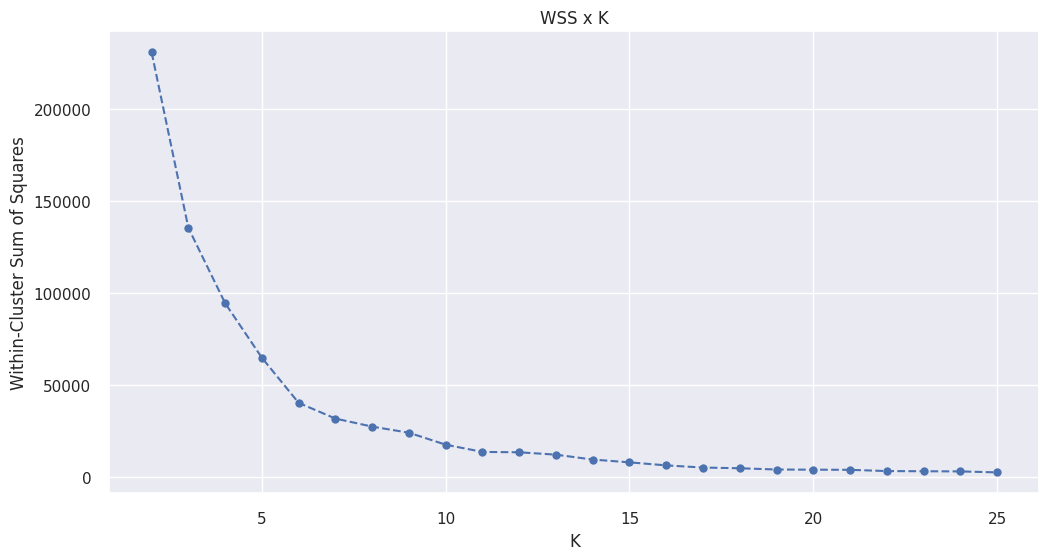

In [100]:
wss = []
for k in clusters:
    # model definition
    kmeans = KMeans(init='random', n_clusters=k, n_init=10, max_iter=300, random_state=CFG.seed)
    
    # model training
    kmeans.fit(X)
    
    # validation    
    wss.append(kmeans.inertia_)

# plot wss - Elbow Method - Método Cotovelo
plt.plot(clusters, wss, linestyle='--', marker='o', color='b')
plt.xlabel('K')
plt.ylabel('Within-Cluster Sum of Squares')
plt.title('WSS x K');

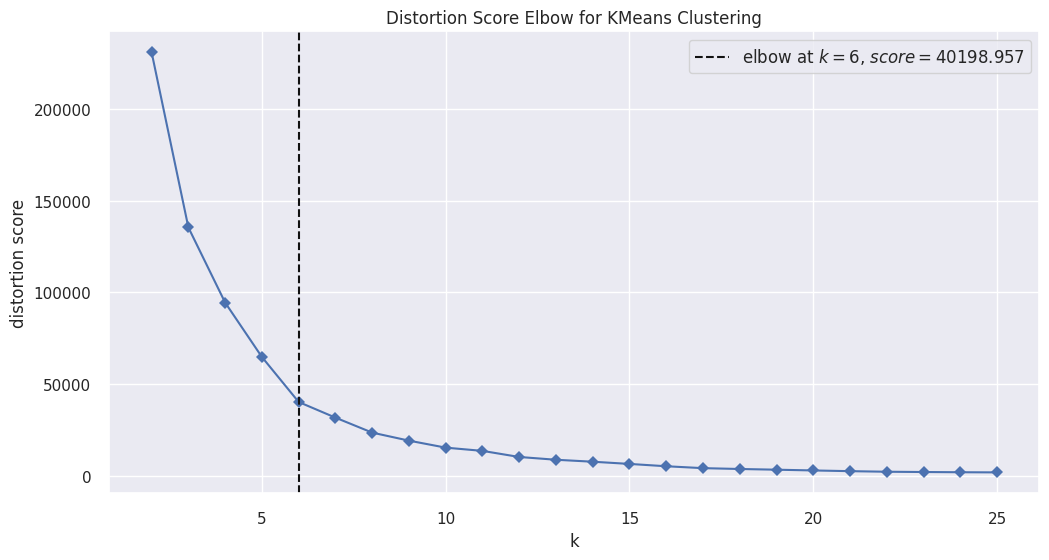

In [101]:
kmeans = KElbowVisualizer(KMeans(n_init=10), k=clusters, timings=False)
kmeans.fit(X)
kmeans.show();

# 8.0 Model Training

## 8.1. Models Configuration

In [113]:
# Nº Components
k = 8

# Model Selection
model_final = GaussianMixture(n_components=k, n_init=1, random_state=42)

# Model Training
model_final.fit(X)

# Clustering
labels = model_final.predict(X)

In [114]:
labels

array([2, 2, 2, ..., 1, 1, 7])

## 8.2. Cluster Validation

In [115]:
## WSS 
# print(f'WSS value: {model_final.inertia_}')

## SS
print(f'SS value: {silhouette_score(X, labels, metric="euclidean")}')

SS value: 0.39887940883636475


# 9.0 Cluster Analysis

In [117]:
# reducer = umap.UMAP(n_neighbors=90, random_state=42)
# embedding = reducer.fit_transform(X)

# # embedding
# # df_umap_viz = df9.drop(columns='customer_id', axis=1)
# df_umap_viz = df9.copy()
# df_umap_viz['embedding_x'] = embedding[:, 0]
# df_umap_viz['embedding_y'] = embedding[:, 1]

# # plot UMAP
# sns.scatterplot(x='embedding_x', y='embedding_y', 
#                 hue='cluster', 
#                 palette=sns.color_palette('hls', n_colors=df_umap_viz['cluster'].nunique()),
#                data=df_umap_viz);

In [105]:
## fig = px.scatter_3d(df9, x='recency', y='frequency', z='monetary', color='cluster')
# fig.show()

In [121]:
df94 = df5[cols_selected].copy()
df94['cluster'] = labels
df94.head()

,customer_id,monetary,recency,frequency,qtde_products,qtde_returns,cluster
0,17850,5391.21,372.0,17.000000,297.0,40.0,2
1,13047,3232.59,56.0,0.028302,171.0,35.0,2
2,12583,6705.38,2.0,0.040323,232.0,50.0,2
3,13748,948.25,95.0,0.017921,28.0,0.0,3
4,15100,876.00,333.0,0.073171,3.0,22.0,4


In [122]:
pd.options.display.float_format = '{:,.2f}'.format

# Number of customer
df_cluster = df94[['customer_id', 'cluster']].groupby('cluster').count().reset_index()
df_cluster['perc_customer'] = (df_cluster['customer_id'] / df_cluster['customer_id'].sum())*100

# Avg Monetary
df_avg_monetary = df94[['monetary', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_monetary, on='cluster')

# Avg recency days
df_avg_recency = df94[['recency', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_recency, on='cluster')

# Avg Frequency
df_avg_frequency = df94[['frequency', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_frequency, on='cluster')

# Avg Qtde Products
df_avg_products = df94[['qtde_products', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_products, on='cluster')

# Avg Qtde Returns
df_avg_returns = df94[['qtde_returns', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_returns, on='cluster')

df_cluster.sort_values(by='monetary', ascending=False)

,cluster,customer_id,perc_customer,monetary,recency,frequency,qtde_products,qtde_returns
5,5,509,8.94,"7,615.14",124.25,0.56,363.07,421.13
2,2,708,12.43,"3,257.07",72.94,0.31,205.82,31.18
1,1,893,15.68,"2,224.09",80.32,0.30,104.24,7.46
3,3,580,10.18,"1,062.08",76.83,0.08,42.85,7.33
4,4,782,13.73,630.32,103.66,0.26,18.53,5.84
7,7,818,14.36,523.22,160.26,1.02,32.18,2.87
0,0,906,15.91,520.17,160.28,0.87,37.78,3.18
6,6,499,8.76,190.52,155.01,0.93,7.23,3.86


In [123]:
np.argmax(df_cluster['monetary'])

5

### Cluster 01:  (Premium - Candidato à Insider)
    - Número de customers: 6 (0,14% dos clientes)
    - Recência média: 7 dias
    - Compras em média: 89 compras
    - Receita em média: U$ 182.182,00 
    
### Cluster 02: (VIPs)
    - Número de customers: 31 (0,71% dos clientes)
    - Recência média: 14 dias
    - Compras em média: 53 compras
    - Receita em média: U$ 40.543,52 
    
### Cluster 03: (Ocasionais)
    - Número de customers: 4.335 (99% dos clientes)
    - Recência média: 92 dias
    - Compras em média: 5 compras
    - Receita em média: U$ 1.372,57 


1. Fenômeno
1. Entidades
    1. Customer
    1. Store
    1. Product

1. Características das Entidades
    1. Nome
    1. Idade
    1. Salário
    1. Escolaridade

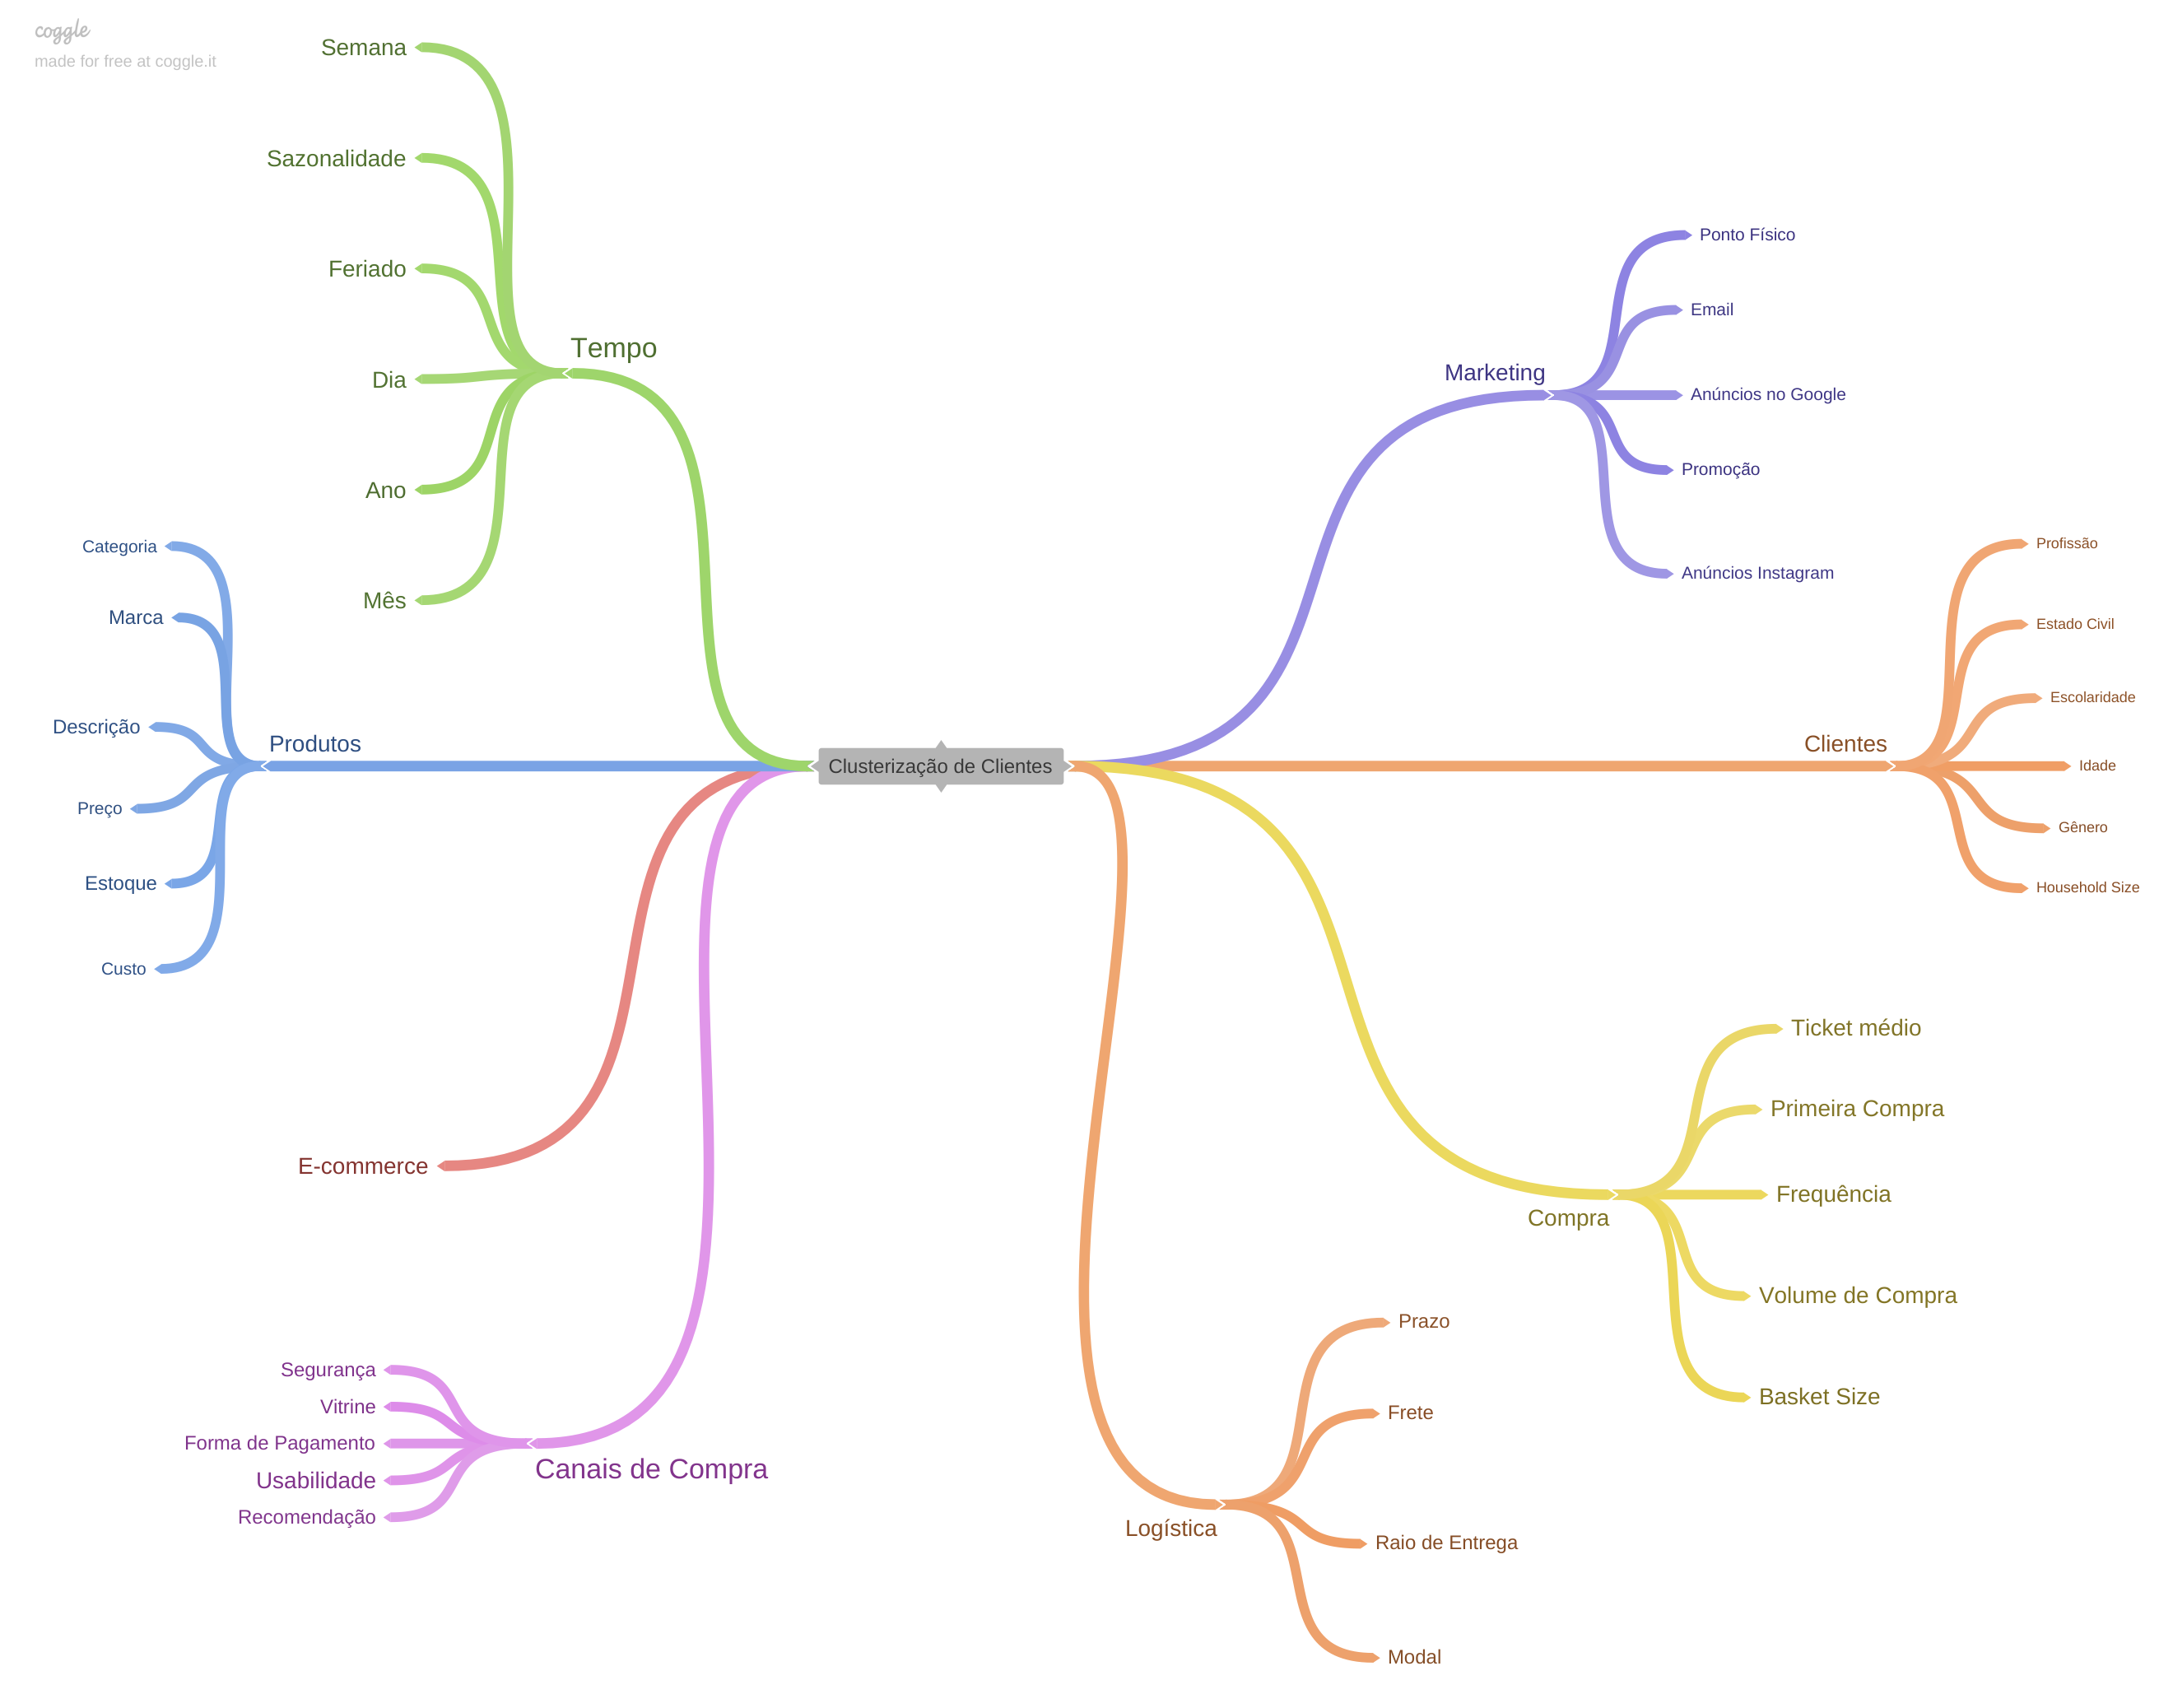

In [159]:
Image("../docs/Mindmap_Clusterizao_de_Clientes.png", width=1000, height=500)

### Hipóteses Cliente

1. Mais da metade dos clientes do cluster insiders possuem o estado civil de solteiro.
2. Apenas 10% dos clientes do cluster insiders estão na faixa de 24-35 anos.
3. 5% dos clientes do cluster insiders recebem mais de 100 mil dólares anualmente.
4. 90% dos clientes do cluster insiders tem ensino superior completo.
5. A maior parte das localidades das entregas do cluster Insiders estão dentro de um raio de 50km.

Não possuimos informação suficiente para validar as features acima, iremos seguir apenas com outras hipóteses.

### Hipóteses Compra

1. A maioria dos clientes 'Insiders' utilizam como forma de pagamento cartão de crédito.
1. Os clientes do cluster Insiders possuem um Ticket Médio de 10% acima do cluster "concorrente".
1. Os clientes do cluster Insiders possuem um Basket Size acima de 5 produtos.

1. **Os clientes do cluster Insiders possuem um Volume de Compras acima de 10% do total de compras.**
1. **Os clientes do cluster Insiders possuem um Faturamento acima de 10% do total de compras.**
1. **Os clientes do cluster Insiders possuem um número de devolução abaixo da média da base total de clientes.**

### Hipóteses Produtos

1. Um terço dos produtos em pacotes grandes são comprados pelos clientes do cluster insiders.
1. **A mediana dos preços dos produtos comprados pelos clientes do cluster Insiders é 10% maior que a mediana de todos os preços dos produtos.**
1. O peso médio dos produtos comprados pelos clientes do cluster Insiders é maior que o peso médio dos outros clusters.
1. A idade média dos produtos comprados pelos clientes do cluster Insiders é menor que 15 dias.

**H1. Os clientes do cluster Insiders possuem um Volume de Compras acima de 10% do total de compras.**

**H2. Os clientes do cluster Insiders possuem um Faturamento acima de 10% do total de compras.**

**H3. Os clientes do cluster Insiders possuem um número de devolução abaixo da média da base total de clientes.**

**H4. A mediana dos preços dos produtos comprados pelos clientes do cluster Insiders é 10% maior que a mediana de todos os preços dos produtos.**

In [177]:
df10.sort_values(by='monetary', ascending=False).head()

,customer_id,monetary,recency,frequency,qtde_products,qtde_returns,cluster
1017,14646,"279,138.02",1.00,0.20,"2,060.00",288.00,6
492,18102,"259,657.30",0.00,0.16,431.00,0.00,6
433,17450,"194,550.79",8.00,0.13,337.00,952.00,6
3338,16446,"168,472.50",0.00,0.01,3.00,"80,995.00",6
66,14911,"140,438.72",1.00,0.53,"5,670.00","3,332.00",6


Nossa hipótese assume que o volume de compras do principal cluster é acima de 10% do total de compras de todos os clusters. Vamos verificar:

In [191]:
cluster_insider = int(df_cluster.loc[df_cluster['monetary'] == df_cluster['monetary'].max(), 'cluster'].values)
cluster_insider

3

In [180]:
# Cluster Insiders
insiders = df10.loc[df10['cluster'] == cluster_insider]
insiders['qtde_products'].sum() > df10['qtde_products'].sum() * 0.1

True

In [181]:
insiders['qtde_products'].sum() / df10['qtde_products'].sum() *100

23.315736274843715

**Verdadeira. O cluster Insiders possui um volume de 23.32% do total de compras.** 

In [118]:
# Cluster Insiders
insiders['monetary'].sum() > df10['monetary'].sum() * 0.1

True

In [119]:
insiders['monetary'].sum() / df10['monetary'].sum() * 100

24.135791791611872

**Verdadeira. O cluster Insiders possui um faturamento de 24.14% do total de compras.** 

In [144]:
insiders['qtde_returns'].mean() < df10['qtde_returns'].mean()

False

In [145]:
insiders['qtde_returns'].mean(), df10['qtde_returns'].mean()

(82.3201581027668, 62.17789757412399)

**Falso. O cluster Insiders possui uma quantidade de devoluções acima da média do total de clientes.** 

In [141]:
insiders['monetary'].median() > df10['monetary'].median() * 0.1

True

In [142]:
insiders['qtde_products'].median() > df10['qtde_products'].median() * 0.1

True

In [138]:
insiders['monetary'].median() / df10['monetary'].median() * 100

598.7231808090205

In [143]:
insiders['qtde_products'].median() / df10['qtde_products'].median() * 100

404.4776119402985

- 1º Quartil

In [226]:
insiders.loc[insiders['monetary'] <= insiders['monetary'].quantile(0.25)].shape[0]

64

- 2º Quartil

In [227]:
insiders.loc[(insiders['monetary'] > insiders['monetary'].quantile(0.25)) & (insiders['monetary'] <= insiders['monetary'].quantile(0.50))].shape[0]

63

- 3º Quartil

In [228]:
insiders.loc[(insiders['monetary'] > insiders['monetary'].quantile(0.50)) & (insiders['monetary'] <= insiders['monetary'].quantile(0.75))].shape[0]

63

- 4º Quartil

In [229]:
insiders.loc[(insiders['monetary'] > insiders['monetary'].quantile(0.75)) & (insiders['monetary'] <= insiders['monetary'].quantile(1))].shape[0]

63

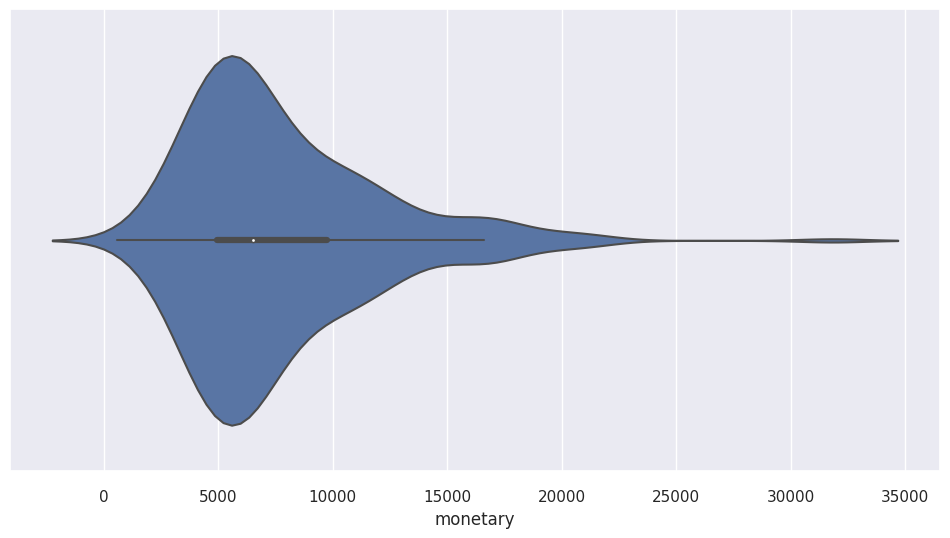

In [150]:
sns.violinplot(x=insiders['monetary']);

### 1. Quem são as pessoas elegíveis para participar do programa insiders?

In [196]:
pd.DataFrame(insiders['customer_id'].head())

,customer_id
2,12583
6,14688
14,12431
20,13767
24,15513


Todos os clientes presentes no dataframe "insiders" (ou seja, do cluster 3), estarão presentes no programa.

### 2. Quantos clientes farão parte do grupo?

In [152]:
insiders.describe().iloc[0][0]

253.0

In [199]:
print(f"Teremos exatamente {insiders['customer_id'].size} clientes no programa.")

Teremos exatamente 253 clientes no programa.


### 3. Quais as principais características desses clientes?

#### Cluster Insider

- Número de customers: 253
- Recência média: 23 dias
- Compras em média: 335 compras
- Frequência de produtos comprados: 0.08 produtos/dia
- Receita em média: U$ 7.785,59

In [201]:
# insiders_monetary = insiders['monetary']

# # Bootstrap
# stats.t.interval(alpha=0.95,
#         df=len(insiders_monetary)-1,
#         loc=np.mean(insiders_monetary),
#         scale=stats.sem(insiders_monetary)
#         )

Intervalo de confiança gerado pelo teste T-Student para o cluster *Insiders*. Todos dentro deste intervalo estão elegíveis.

### 4. Qual a porcentagem de contribuição do faturamento, vinda do programa?

In [233]:
print(f"GMV de contribuição do grupo Insiders: {insiders['monetary'].sum()/df10['monetary'].sum()*100:.2f}%")

GMV de contribuição do grupo Insiders: 24.14%


### 5. Qual a expectativa de faturamento (LTV) desse grupo para os próximos meses?

### 6. Quais as condições para uma pessoa ser elegível aos insiders?

### 7. Quais as condições para um apessoa ser removida dos insiders?

### 8. Qual a garantia que o programa _insiders_ é melhor que o restante da base?

### 9. Quais ações o time de marketing pode realizar para aumentar o faturamento?

# 11.0 Deployment

In [125]:
df94.dtypes

customer_id        int64
monetary         float64
recency          float64
frequency        float64
qtde_products    float64
qtde_returns     float64
cluster            int64
dtype: object

## 11.1 Insert into SQLite

In [149]:
import sqlite3
from sqlalchemy import create_engine

In [126]:
df94['recency'] = df94['recency'].astype(int)
df94['qtde_products'] = df94['qtde_products'].astype(int)
df94['qtde_returns'] = df94['qtde_returns'].astype(int)

In [150]:
# Create table
query_delete_if_exists = """
    DROP TABLE IF EXISTS insiders
    """

query_create_table_insiders = """
    CREATE TABLE insiders (
    customer_id INTEGER,
    monetary REAL,
    recency INTEGER,
    frequency REAL,
    qtde_products INTEGER,
    qtde_returns INTEGER,
    cluster INTEGER
    )
"""

conn = sqlite3.connect("insiders_db.sqlite")
conn.execute(query_delete_if_exists)
conn.execute(query_create_table_insiders)
conn.commit()
conn.close()

# Insert Data
conn = create_engine("sqlite:///insiders_db.sqlite")
df94.to_sql('insiders', con=conn, if_exists='append', index=False)

# Select Data

5695

In [151]:
# Consulting Data
query = """
    SELECT * FROM insiders

"""

df = pd.read_sql_query(query, conn)

In [153]:
df.head()

,customer_id,monetary,recency,frequency,qtde_products,qtde_returns,cluster
0,17850,"5,391.21",372,17.00,297,40,2
1,13047,"3,232.59",56,0.03,171,35,2
2,12583,"6,705.38",2,0.04,232,50,2
3,13748,948.25,95,0.02,28,0,3
4,15100,876.00,333,0.07,3,22,4


In [155]:
df.shape

(5695, 7)

# 12.0 SandBox

## 12.1. Original Dataset

## 12.2. Silhouette Analysis